The dataset was created by a team during the NASA Space Apps Challenge in 2018.
We are trying to train a model to distinguish between the images that contain fire and regular images. The problem is a binary classification problem. The 2 classes (fire/non-fire) don't have an equal number of samples.

# IMPORTS

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization,MaxPooling2D,BatchNormalization
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [51]:
Fire_Dataset_Path = Path("fire_dataset")
PNG_Path = list(Fire_Dataset_Path.glob(r"*/*.png"))
PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],PNG_Path))

In [52]:
print("The number of pictures with fire is: ", PNG_Labels.count("fire_images"))
print("The number of pictures without fire is: ", PNG_Labels.count("non_fire_images"))

The number of pictures with fire is:  755
The number of pictures without fire is:  244


In [53]:
PNG_Path_Series = pd.Series(PNG_Path,name="PNG").astype(str)
PNG_Labels_Series = pd.Series(PNG_Labels,name="CATEGORY")
PNG_Labels_Series.replace({"non_fire_images":"NO_FIRE","fire_images":"FIRE"},inplace=True)

In [54]:
Main_Train_Data = pd.concat([PNG_Path_Series,PNG_Labels_Series],axis=1)
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)

In [55]:
remove_PNG = '../input/fire-dataset/fire_dataset/non_fire_images/non_fire.32.png'
Main_Train_Data = Main_Train_Data.loc[~(Main_Train_Data.loc[:,'PNG'] == remove_PNG),:]

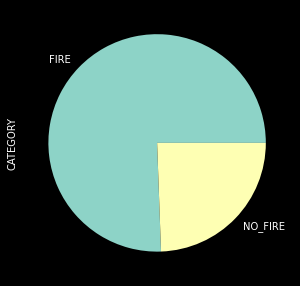

In [56]:
plt.style.use("dark_background")
Main_Train_Data['CATEGORY'].value_counts().plot.pie(figsize=(5,5))
plt.show()

Text(0.5, 1.0, 'NO_FIRE')

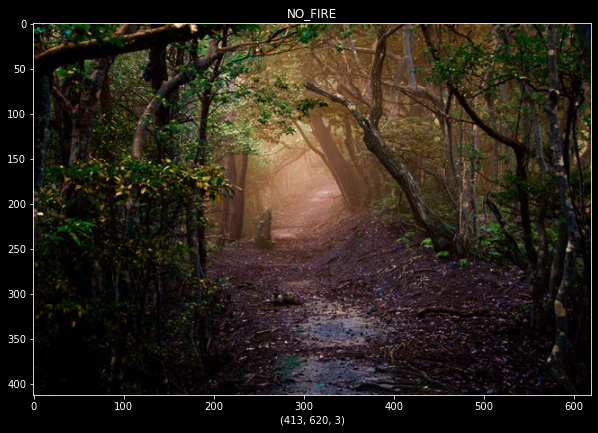

In [57]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(Main_Train_Data["PNG"][0])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Train_Data["CATEGORY"][0])

Text(0.5, 1.0, 'FIRE')

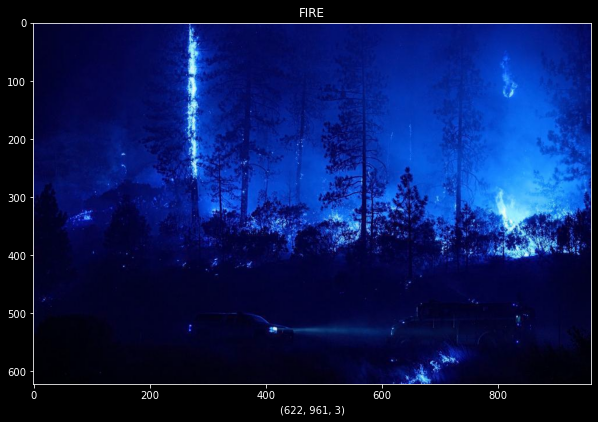

In [58]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(Main_Train_Data["PNG"][48])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Train_Data["CATEGORY"][48])

In [59]:
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)
Test_Generator = ImageDataGenerator(rescale=1./255)

In [60]:
Train_Data,Test_Data = train_test_split(Main_Train_Data,train_size=0.9,random_state=42,shuffle=True)

In [61]:
encode = LabelEncoder()
For_Prediction_Class = encode.fit_transform(Test_Data["CATEGORY"])

In [62]:
example_Image = Train_Data["PNG"][99]
Load_Image = image.load_img(example_Image,target_size=(200,200))
Array_Image = image.img_to_array(Load_Image)
Array_Image = Array_Image.reshape((1,) + Array_Image.shape)

In [63]:
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="training")

Found 810 validated image filenames belonging to 2 classes.


In [64]:
Validation_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="validation")

Found 89 validated image filenames belonging to 2 classes.


In [65]:
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=Test_Data,
                                                 x_col="PNG",
                                                 y_col="CATEGORY",
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=32)

Found 100 validated image filenames belonging to 2 classes.


In [66]:
print("TRAIN: ")
print(Train_IMG_Set.class_indices)
print(Train_IMG_Set.classes[0:5])
print(Train_IMG_Set.image_shape)
print("---"*20)
print("VALIDATION: ")
print(Validation_IMG_Set.class_indices)
print(Validation_IMG_Set.classes[0:5])
print(Validation_IMG_Set.image_shape)
print("---"*20)
print("TEST: ")
print(Test_IMG_Set.class_indices)
print(Test_IMG_Set.classes[0:5])
print(Test_IMG_Set.image_shape)

TRAIN: 
{'FIRE': 0, 'NO_FIRE': 1}
[0, 1, 0, 0, 1]
(256, 256, 3)
------------------------------------------------------------
VALIDATION: 
{'FIRE': 0, 'NO_FIRE': 1}
[0, 0, 0, 0, 0]
(256, 256, 3)
------------------------------------------------------------
TEST: 
{'FIRE': 0, 'NO_FIRE': 1}
[0, 0, 0, 0, 0]
(256, 256, 3)


In [67]:
Model = Sequential()

Model.add(Conv2D(32,(3,3),activation="relu",
                 input_shape=(256,256,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2)))

Model.add(Conv2D(64,(3,3),
                 activation="relu",padding="same"))
Model.add(Dropout(0.1))
Model.add(MaxPooling2D((2,2)))

Model.add(Conv2D(128,(3,3),
                 activation="relu",padding="same"))
Model.add(Dropout(0.1))
Model.add(MaxPooling2D((2,2)))

Model.add(Flatten())
Model.add(Dense(256,activation="relu"))
Model.add(Dropout(0.1))
Model.add(Dense(1,activation="sigmoid"))

In [68]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5,mode="min")

In [69]:
Model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
CNN_Model = Model.fit(Train_IMG_Set,
                      validation_data=Validation_IMG_Set,
                            callbacks=Call_Back,
                      epochs=2)

Epoch 1/2
26/26 [==============================] - 85s 3s/step - loss: 13.3598 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/2
26/26 [==============================] - 84s 3s/step - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [70]:
print(Model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_26 (ModuleWra (None, None, None, 32)    896       
_________________________________________________________________
module_wrapper_27 (ModuleWra (None, None, None, 32)    128       
_________________________________________________________________
module_wrapper_28 (ModuleWra (None, None, None, 32)    0         
_________________________________________________________________
module_wrapper_29 (ModuleWra (None, None, None, 64)    18496     
_________________________________________________________________
module_wrapper_30 (ModuleWra (None, None, None, 64)    0         
_________________________________________________________________
module_wrapper_31 (ModuleWra (None, None, None, 64)    0         
_________________________________________________________________
module_wrapper_32 (ModuleWra (None, None, None, 128)  

In [71]:
plot_model(Model,to_file="Model_One.png",show_layer_names=True,show_dtype=True,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [72]:
Model_Results = Model.evaluate(Test_IMG_Set)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

4/4 [==============================] - 2s 464ms/step - loss: 0.6931 - accuracy: 0.5000
LOSS:  0.6931
ACCURACY:  0.50


No handles with labels found to put in legend.


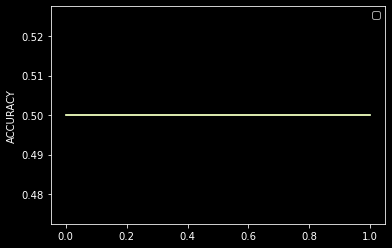

In [73]:
plt.plot(CNN_Model.history["accuracy"])
plt.plot(CNN_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

No handles with labels found to put in legend.


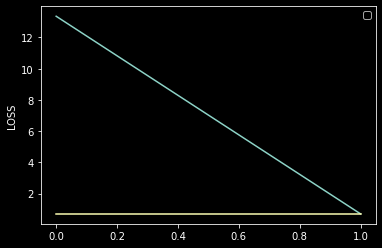

In [74]:
plt.plot(CNN_Model.history["loss"])
plt.plot(CNN_Model.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.show()

No handles with labels found to put in legend.


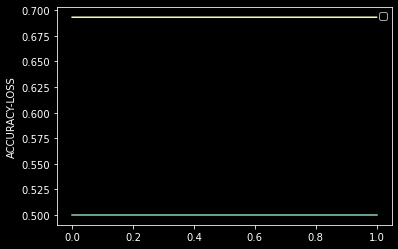

In [75]:
plt.plot(CNN_Model.history["val_accuracy"])
plt.plot(CNN_Model.history["val_loss"])
plt.ylabel("ACCURACY-LOSS")
plt.legend()
plt.show()

<AxesSubplot:>

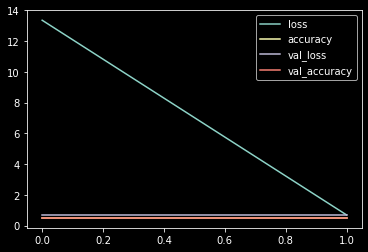

In [76]:
Dict_Summary_One = pd.DataFrame(CNN_Model.history)
Dict_Summary_One.plot()

In [77]:
Prediction_One = Model.predict(Test_IMG_Set)
Prediction_One = Prediction_One.argmax(axis=-1)
Predict_Class = Model.predict_classes(Test_IMG_Set)
print(Predict_Class)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


* {'FIRE': 0, 'NO_FIRE': 1}

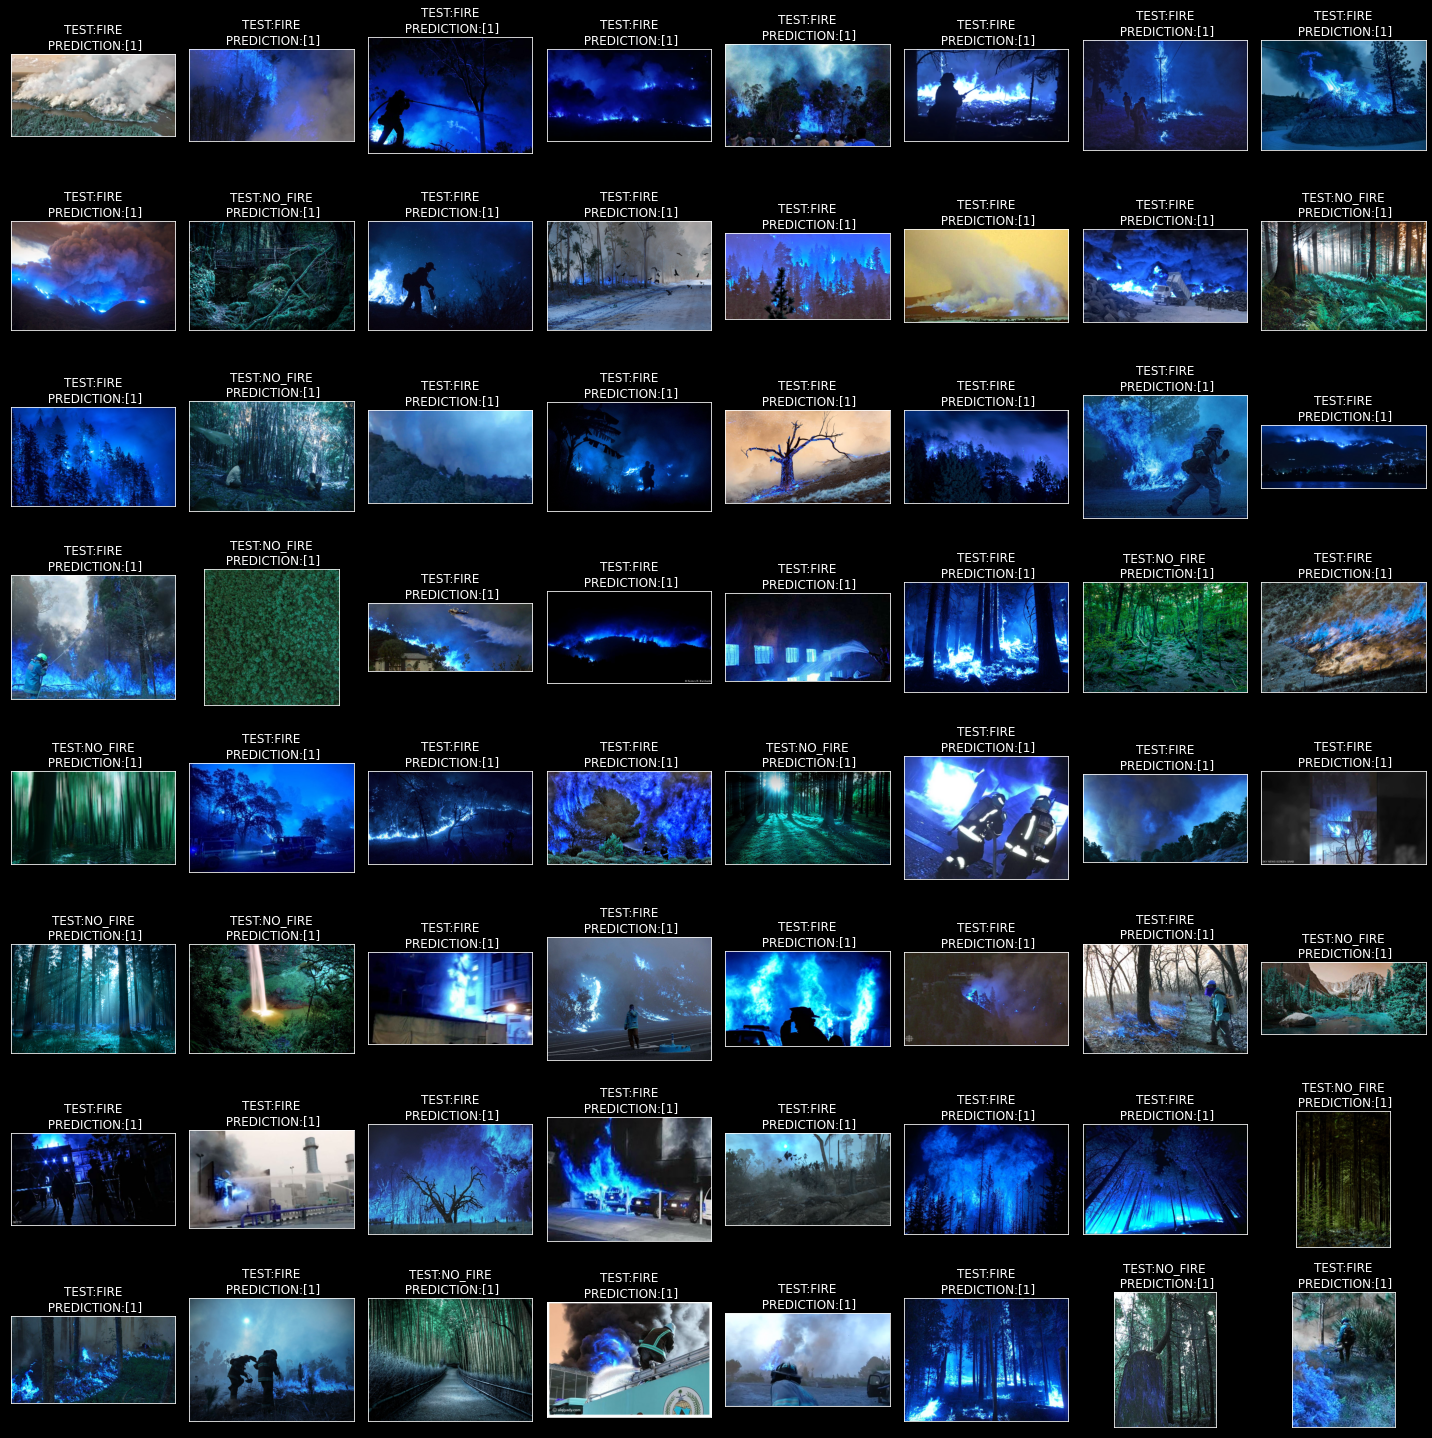

In [78]:
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(Test_Data["PNG"].iloc[i]))
    ax.set_title(f"TEST:{Test_Data.CATEGORY.iloc[i]}\n PREDICTION:{Predict_Class[i]}")
plt.tight_layout()
plt.show()

In [79]:
print(confusion_matrix(For_Prediction_Class,Predict_Class))

[[ 0 77]
 [ 0 23]]


In [80]:
print(classification_report(For_Prediction_Class,Predict_Class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.23      1.00      0.37        23

    accuracy                           0.23       100
   macro avg       0.12      0.50      0.19       100
weighted avg       0.05      0.23      0.09       100



In [81]:
image_path = "fire_dataset\\fire_images\\fire.1.png"
img = image.load_img(image_path,target_size=(256,256))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
Diff_Pred = Model.predict(x)
Diff_Pred = Diff_Pred.argmax(axis=-1)
print(Diff_Pred)

[0]


In [82]:
image_path_Two = "fire_dataset\\non_fire_images\\non_fire.12.png"
img_Two = image.load_img(image_path_Two,target_size=(256,256))
x_Two = image.img_to_array(img_Two)
x_Two = np.expand_dims(x_Two,axis=0)
Diff_Pred_Two = Model.predict(x_Two)
Diff_Pred_Two = Diff_Pred_Two.argmax(axis=-1)
print(Diff_Pred_Two)

[0]


In [83]:
Model_Two = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(256,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2,activation="softmax")
])

In [84]:
Model_Two.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [85]:
ANN_Model = Model_Two.fit(Train_IMG_Set,
                          validation_data=Validation_IMG_Set,
                          callbacks=Call_Back,
                      epochs=2)

Epoch 1/2
26/26 [==============================] - 30s 1s/step - loss: 0.4597 - accuracy: 0.7716 - val_loss: 0.3228 - val_accuracy: 0.8427
Epoch 2/2
26/26 [==============================] - 28s 1s/step - loss: 0.3395 - accuracy: 0.8395 - val_loss: 0.2711 - val_accuracy: 0.8764


In [86]:
print(Model_Two.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, None, None, None)  0         
_________________________________________________________________
flatten_1 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               25165952  
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 25,174,338
Trainable params: 25,174,338
Non-trainable params: 0
__________________________________________

In [87]:
plot_model(Model_Two,to_file="Model_Two.png",show_layer_names=True,show_dtype=True,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [88]:
Model_Results_Two = Model_Two.evaluate(Test_IMG_Set)
print("LOSS:  " + "%.4f" % Model_Results_Two[0])
print("ACCURACY:  " + "%.2f" % Model_Results_Two[1])

4/4 [==============================] - 1s 165ms/step - loss: 0.4578 - accuracy: 0.8300
LOSS:  0.4578
ACCURACY:  0.83


No handles with labels found to put in legend.


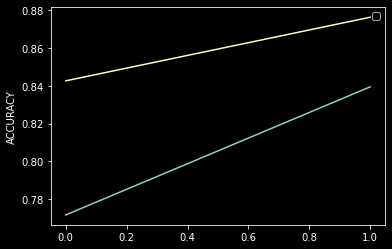

In [89]:
plt.plot(ANN_Model.history["accuracy"])
plt.plot(ANN_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

No handles with labels found to put in legend.


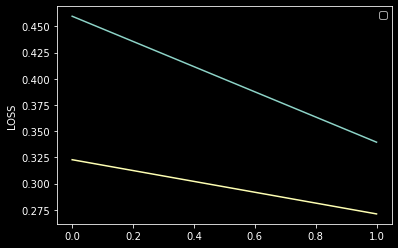

In [90]:
plt.plot(ANN_Model.history["loss"])
plt.plot(ANN_Model.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.show()

No handles with labels found to put in legend.


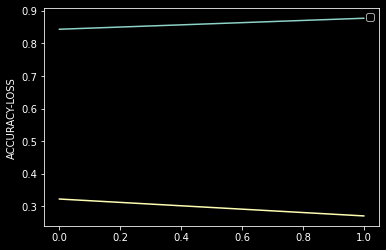

In [91]:
plt.plot(ANN_Model.history["val_accuracy"])
plt.plot(ANN_Model.history["val_loss"])
plt.ylabel("ACCURACY-LOSS")
plt.legend()
plt.show()

<AxesSubplot:>

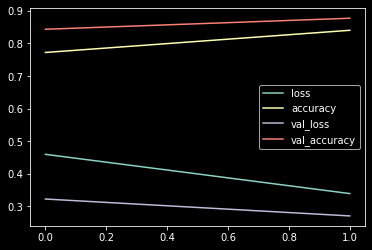

In [92]:
Dict_Summary_Two = pd.DataFrame(ANN_Model.history)
Dict_Summary_Two.plot()

In [93]:
image_path = "fire_dataset\\fire_images\\fire.100.png"
img = image.load_img(image_path,target_size=(256,256))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
Diff_Pred = Model_Two.predict(x)
Diff_Pred = Diff_Pred.argmax(axis=-1)
print(Diff_Pred)

[0]


In [94]:
image_path_Two = "fire_dataset\\non_fire_images\\non_fire.97.png"
img_Two = image.load_img(image_path_Two,target_size=(256,256))
x_Two = image.img_to_array(img_Two)
x_Two = np.expand_dims(x_Two,axis=0)
Diff_Pred_Two = Model_Two.predict(x_Two)
Diff_Pred_Two = Diff_Pred_Two.argmax(axis=-1)
print(Diff_Pred_Two)

[1]
